In [47]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

### Load the Datasets

In [48]:
# Load the training and validation datasets
train_df = pd.read_csv('./Data/train.csv', sep='\t')
val_df = pd.read_csv('./Data/dev.csv', sep='\t')
test_df = pd.read_csv('./Data/sample_demo.csv', sep='\t')

print(len(train_df), len(val_df), len(test_df))
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

print("Training data shape: ", train_df.shape)
print("Validation data shape: ", val_df.shape)
print("Test data shape: ", test_df.shape)
train_df.head()

5711 1470 6
Training data shape:  (5708, 3)
Validation data shape:  (1468, 3)
Test data shape:  (6, 4)


,score,sentence1,sentence2
0,5.00,A plane is taking off.,An air plane is taking off.
1,3.80,A man is playing a large flute.,A man is playing a flute.
2,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.60,Three men are playing chess.,Two men are playing chess.
4,4.25,A man is playing the cello.,A man seated is playing the cello.


### Scale the Score Data Column

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df['score'] = scaler.fit_transform(train_df[['score']])
val_df['score'] = scaler.fit_transform(val_df[['score']])
test_df['score'] = scaler.fit_transform(test_df[['score']])

train_df.head()

,score,sentence1,sentence2
0,1.00,A plane is taking off.,An air plane is taking off.
1,0.76,A man is playing a large flute.,A man is playing a flute.
2,0.76,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,0.52,Three men are playing chess.,Two men are playing chess.
4,0.85,A man is playing the cello.,A man seated is playing the cello.


### Load the Model

In [37]:
from sentence_transformers import SentenceTransformer, util, SentencesDataset, InputExample, losses
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from torch.optim import Adam

# all-mpnet-base-v2 (large-size), all-MiniLM-L12-v1 (moderate), all-MiniLM-L6-v2 (fast & good & small), paraphrase-mpnet-base-v2
model = SentenceTransformer("all-MiniLM-L6-v2")

### Fine-tune the Model

In [8]:
from torch.utils.data import DataLoader

# Define Train and Validation Dataset
train_dataset = [InputExample(texts=[train_df.iloc[i]['sentence1'], train_df.iloc[i]['sentence2']], label=torch.tensor(train_df.iloc[i]['score'], dtype=torch.float32)) for i in range(len(train_df))]
val_dataset = [InputExample(texts=[val_df.iloc[i]['sentence1'], val_df.iloc[i]['sentence2']], label=torch.tensor(val_df.iloc[i]['score'], dtype=torch.float32)) for i in range(len(val_df))]
test_dataset = [InputExample(texts=[test_df.iloc[i]['sentence1'], test_df.iloc[i]['sentence2']], label=torch.tensor(test_df.iloc[i]['score'], dtype=torch.float32)) for i in range(len(test_df))]

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [9]:
def cosine_similarity_loss(model, df):
    predicted = []
    for i in range(len(df)):
        emb1 = model.encode(df.iloc[i]['sentence1'], convert_to_tensor=True)
        emb2 = model.encode(df.iloc[i]['sentence2'], convert_to_tensor=True)
        cosine_sim = util.pytorch_cos_sim(emb1, emb2)
        predicted.append(cosine_sim)
    predicted = torch.tensor(predicted)
    actual = torch.tensor(df['score'].values)
    return mse_loss(predicted, actual)


# Define loss functions
num_epochs = 3
loss = losses.CosineSimilarityLoss(model)
mse_loss = torch.nn.MSELoss()
cos_score_transformation = torch.nn.Identity()
optimizer = Adam(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    model = model.to(device)
    model.fit(
        [(train_dataloader, loss)],
        epochs=1  
    )
    train_loss = cosine_similarity_loss(model, train_df)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss}")
    val_loss = cosine_similarity_loss(model, val_df)
    print(f"Epoch {epoch+1}: Validation Loss: {val_loss}")
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

Epoch: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


Epoch 1: Train Loss: 0.019082659721497256
Epoch 1: Validation Loss: 0.02280338787077958


Epoch: 100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


Epoch 2: Train Loss: 0.018695808406530148
Epoch 2: Validation Loss: 0.022525595089060324


Epoch: 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


Epoch 3: Train Loss: 0.01840701227053525
Epoch 3: Validation Loss: 0.022342123995003287


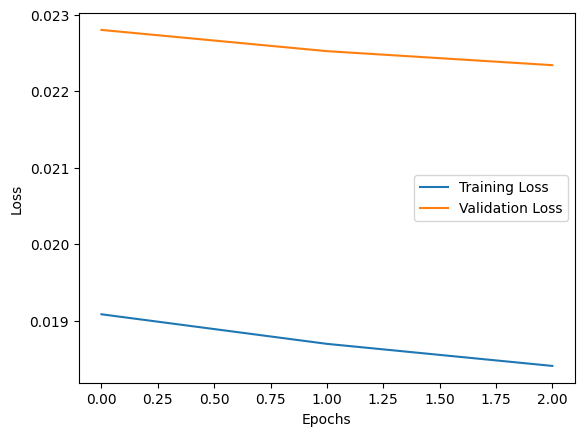

In [11]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
val_loss = cosine_similarity_loss(model, val_df)
print(f"Validation Loss: {val_loss}")
test_loss = cosine_similarity_loss(model, test_df)
print(f"Test Loss: {test_loss}")

Validation Loss: 0.022342123995003287
Test Loss: 0.27213488187773915


### Save the Model

In [13]:
model = model.to('cpu')
torch.save(model.state_dict(), 'q1c_sbert_model.pth')

In [14]:
loaded_model = SentenceTransformer("all-MiniLM-L6-v2")
loaded_model.load_state_dict(torch.load('q1c_sbert_model.pth'))
loaded_model = loaded_model.to(device)

val_loss = cosine_similarity_loss(loaded_model, val_df)
print(f"Validation Loss: {val_loss}")
test_loss = cosine_similarity_loss(loaded_model, test_df)
print(f"Test Loss: {test_loss}")

Validation Loss: 0.022342123995003287
Test Loss: 0.27213488187773915


### Report the Pearson Correlation Coefficient 

In [26]:
def calculate_similarity_score(model, df):
    predicted = []
    for i in range(len(df)):
        emb1 = model.encode(df.iloc[i]['sentence1'], convert_to_tensor=True)
        emb2 = model.encode(df.iloc[i]['sentence2'], convert_to_tensor=True)
        cosine_sim = util.pytorch_cos_sim(emb1, emb2)
        predicted.append(cosine_sim.item())
    return predicted


val_predicted = calculate_similarity_score(loaded_model, val_df)
pearson_val, _ = pearsonr(val_predicted, val_df['score'])
print(f"Validation Pearson Score: {pearson_val}")

test_predicted = calculate_similarity_score(loaded_model, test_df)
pearson_test, _ = pearsonr(test_predicted, test_df['score'])
print(f"Test Pearson Score: {pearson_test}")

Validation Pearson Score: 0.8904479023415723
Test Pearson Score: 0.986926101342789
